In [5]:
pip install tensorflow

  Using cached tensorflow-2.12.0-cp39-cp39-win_amd64.whl (1.9 kB)
     ------------------------------------ 272.8/272.8 MB 550.6 kB/s eta 0:00:00
     ------------------------------------ 440.7/440.7 kB 950.3 kB/s eta 0:00:00
     -------------------------------------- 14.7/14.7 MB 436.7 kB/s eta 0:00:00
     -------------------------------------- 24.4/24.4 MB 417.2 kB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 626.6 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.23.5 which is incompatible.


In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "rice_leaf_diseases",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 120 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [10]:
len(dataset)

4

In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 1 1 0 0 1 2 1 1 2 1 0 1 2 0 1 2 2 0 0 0 1 1 0 0 1 2 0 2 2 2]


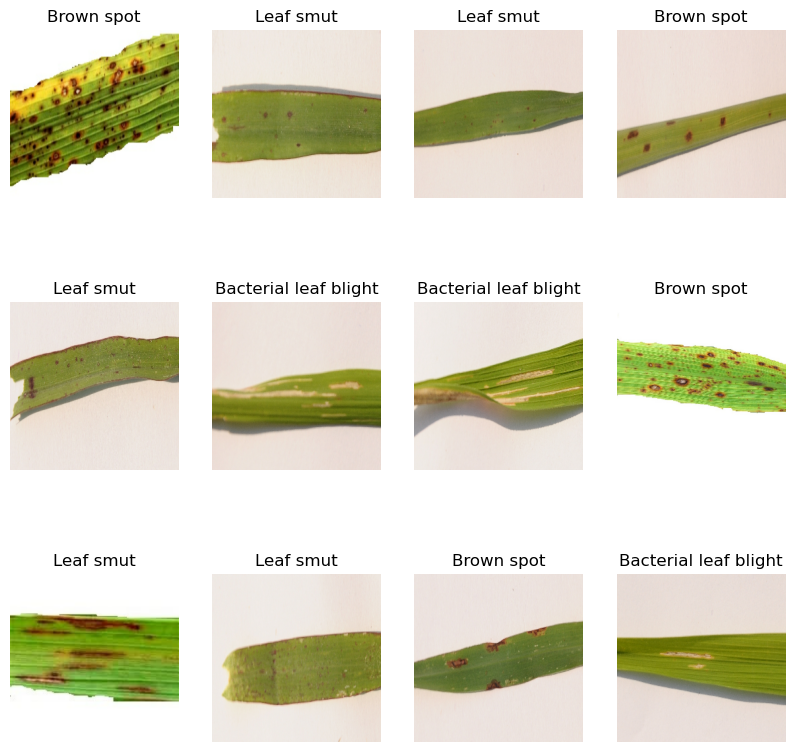

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
len(dataset)

4

In [21]:
train_size = 0.5
len(dataset)*train_size

2.0

In [22]:
train_ds = dataset.take(2)
len(train_ds)

2

In [32]:
test_ds = dataset.skip(2)
len(test_ds)

2

In [33]:
val_size=0.25
len(dataset)*val_size

1.0

In [34]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [35]:
test_ds = test_ds.skip(1)
len(test_ds)

1

In [36]:
def get_dataset_partitions_tf(ds, train_split=0.5, val_split=0.25, test_split=0.25, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [37]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [38]:
len(train_ds)

2

In [39]:
len(val_ds)

1

In [40]:
len(test_ds)

1

In [42]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [44]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [45]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [47]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [48]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
2/2 [==============================] - 4s 1s/step - loss: 1.1070 - accuracy: 0.3750 - val_loss: 1.0728 - val_accuracy: 0.4583
Epoch 2/50
2/2 [==============================] - 2s 780ms/step - loss: 1.0855 - accuracy: 0.3750 - val_loss: 1.0598 - val_accuracy: 0.4583
Epoch 3/50
2/2 [==============================] - 2s 786ms/step - loss: 1.0756 - accuracy: 0.3750 - val_loss: 1.0504 - val_accuracy: 0.4583
Epoch 4/50
2/2 [==============================] - 2s 923ms/step - loss: 1.0733 - accuracy: 0.3750 - val_loss: 1.0350 - val_accuracy: 0.4583
Epoch 5/50
2/2 [==============================] - 2s 729ms/step - loss: 1.0509 - accuracy: 0.3929 - val_loss: 1.0094 - val_accuracy: 0.5000
Epoch 6/50
2/2 [==============================] - 2s 994ms/step - loss: 1.0240 - accuracy: 0.4464 - val_loss: 0.9676 - val_accuracy: 0.5417
Epoch 7/50
2/2 [==============================] - 2s 792ms/step - loss: 0.9805 - accuracy: 0.5000 - val_loss: 0.9362 - val_accuracy: 0.5417
Epoch 8/50
2/2 [=======

In [49]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 0s 355ms/step - loss: 1.4287 - accuracy: 0.7812


In [50]:
scores

[1.428711175918579, 0.78125]

In [51]:
history

In [52]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 2}

In [53]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

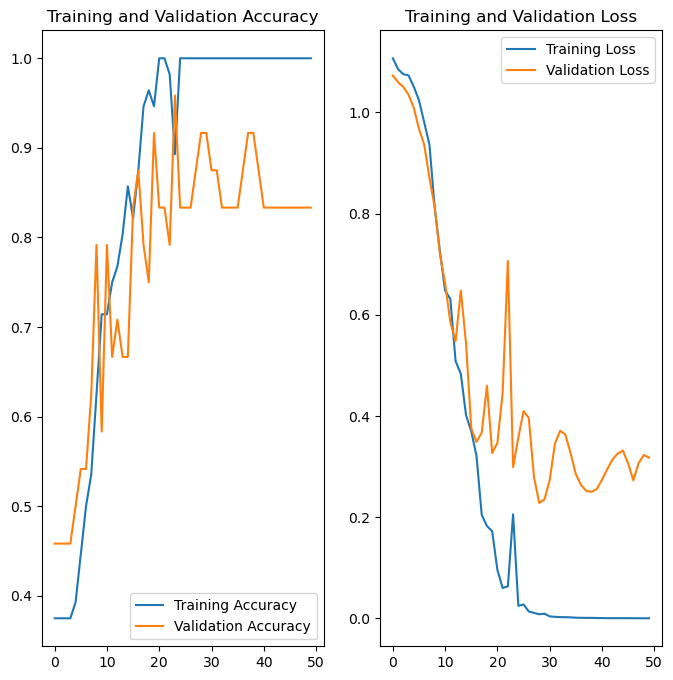

In [56]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Bacterial leaf blight
1/1 [==============================] - 0s 163ms/step
predicted label: Bacterial leaf blight


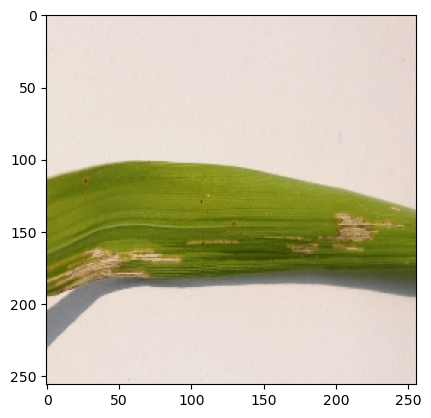

In [72]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    
    first_image = images_batch[2].numpy().astype('uint8')
    first_label = labels_batch[2].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[2])])

In [73]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


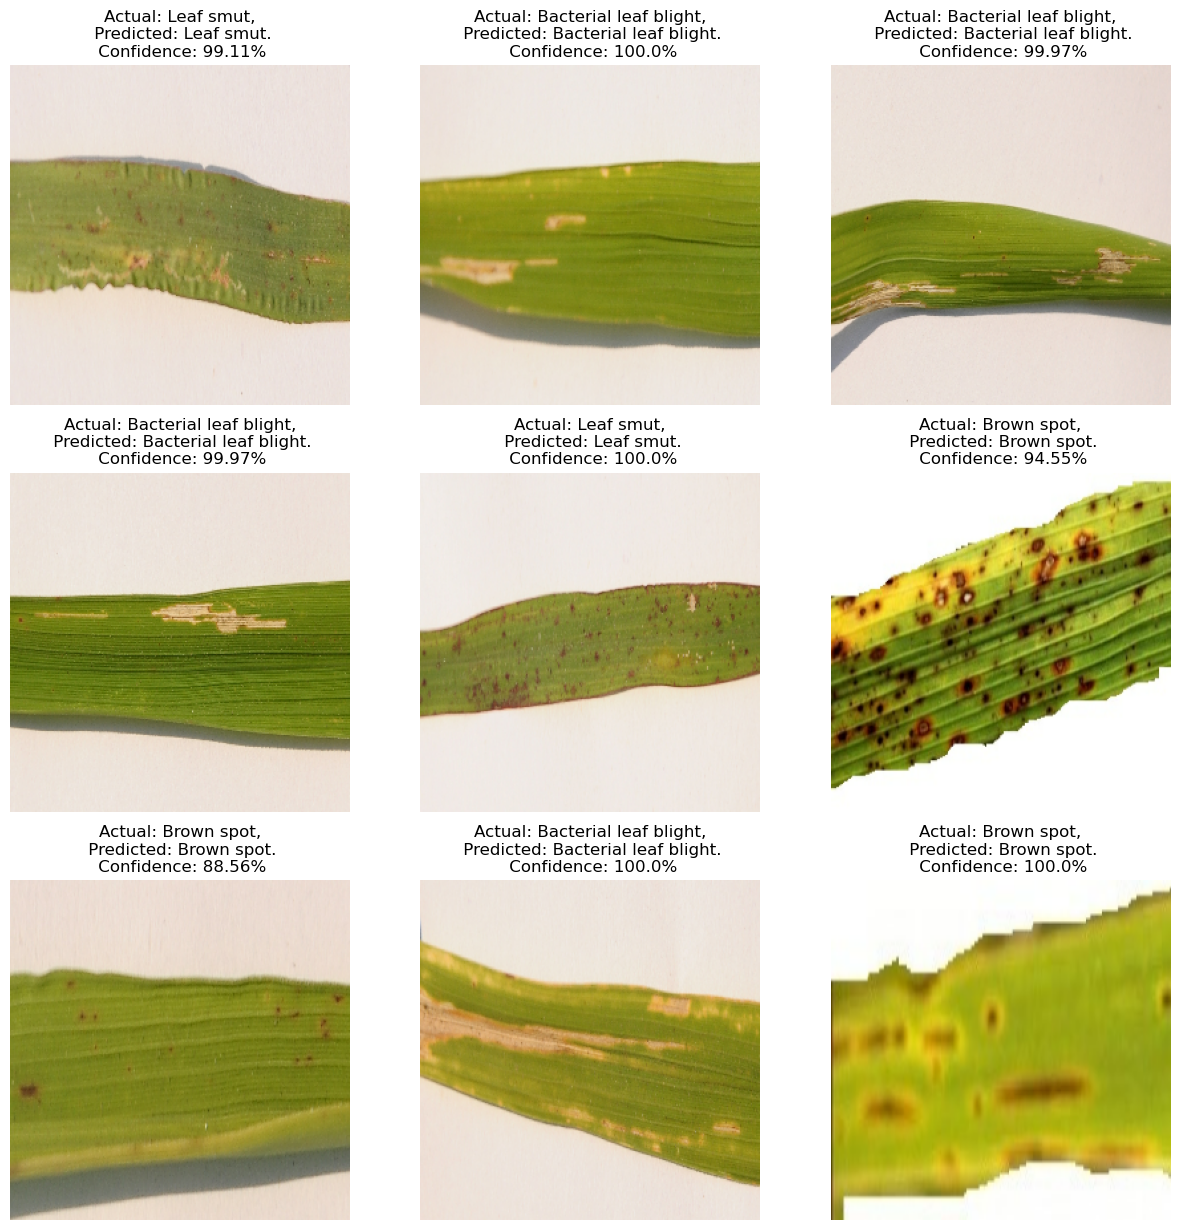

In [74]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [78]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [80]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [81]:
model.save("../paddy.h5")